In [1]:
import csv
import glob
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import spectral_embedding as se

Load the continent data for every airport.

In [2]:
airport_continents = {}
first = True

with open('Flight Network Data/airports.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    for line in reader:
        if first:
            first = False
            continue
        
        airport = line[1]
        continent = line[7]
    
        if continent not in ['NA','AS','EU','SA','OC','AF']:
            airport_continents[airport] = 'XX'
        else:
            airport_continents[airport] = continent

Load the flight data for the year 2019. Ignore any flights that involve an airport without a continent label.

In [3]:
nodes = {}
count = 0

sources = []
targets = []
weights = []

for month in range(12):
    first = True
    
    if month < 9:
        month_str = '0' + str(month+1)
    else:
        month_str = str(month+1)
    
    filename = glob.glob('Flight Network Data/flightlist_2019' + month_str + '*.csv')[0]
    print(month, filename)
    file = open(filename, 'r')
    
    first = True

    for line in file:
        if first:
            first_data = np.array(line.strip('\n').split(','))
            source_idx = np.where(first_data == 'origin')[0][0]
            target_idx = np.where(first_data == 'destination')[0][0]
            time_idx = np.where(first_data == 'firstseen')[0][0]
                
            first = False
            continue
        
        data = line.strip('\n').split(',')
        source = data[source_idx]
        target = data[target_idx]
    
        # Ignore blank entries
        if source == '' or target == '':
            continue
        
        # Ignore self-connections
        if source == target:
            continue
        
        # Ignore XX continent flight sources
        if source not in airport_continents or airport_continents[source] == 'XX':
            continue
        
        # Ignore XX continent flight targets
        if target not in airport_continents or airport_continents[target] == 'XX':
            continue
            
        if source not in nodes:
            nodes[source] = count
            count += 1
        if target not in nodes:
            nodes[target] = count
            count += 1
        
        sources.append(nodes[source])
        targets.append(nodes[target])
        
sources = np.array(sources)
targets = np.array(targets)

0 Flight Network Data/flightlist_20190101_20190131.csv
1 Flight Network Data/flightlist_20190201_20190228.csv
2 Flight Network Data/flightlist_20190301_20190331.csv
3 Flight Network Data/flightlist_20190401_20190430.csv
4 Flight Network Data/flightlist_20190501_20190531.csv
5 Flight Network Data/flightlist_20190601_20190630.csv
6 Flight Network Data/flightlist_20190701_20190731.csv
7 Flight Network Data/flightlist_20190801_20190831.csv
8 Flight Network Data/flightlist_20190901_20190930.csv
9 Flight Network Data/flightlist_20191001_20191031.csv
10 Flight Network Data/flightlist_20191101_20191130.csv
11 Flight Network Data/flightlist_20191201_20191231.csv


In [4]:
n = len(nodes)
print('Number of nodes:', n)

Number of nodes: 15374


Construct the weighted adjacency matrix counting the number of flights between pairs of airports.

In [5]:
A = sparse.coo_matrix((np.ones(len(sources)), (sources, targets)), shape=(n,n))

Colour the airports in the embedding using the continent label.

In [6]:
continent_cols = {
    'NA': 'tab:red',
    'AS': 'tab:blue',
    'EU': 'tab:green',
    'SA': 'tab:orange',
    'OC': 'tab:purple',
    'AF': 'tab:pink'
}

In [7]:
Z = np.array([airport_continents[node] for node in nodes])
Z_colours = np.array([continent_cols[airport_continents[node]] for node in nodes])

In [8]:
fig = plt.figure()
handles = [plt.scatter([],[], color='tab:red', marker='o', s=8, label=r'North America'),
           plt.scatter([],[], color='tab:blue', marker='o', s=8, label=r'Asia'),
           plt.scatter([],[], color='tab:green', marker='o', s=8, label=r'Europe'),
           plt.scatter([],[], color='tab:orange', marker='o', s=8, label=r'South America'),
           plt.scatter([],[], color='tab:purple', marker='o', s=8, label=r'Oceania'),
           plt.scatter([],[], color='tab:pink', marker='o', s=8, label=r'Africa')]
plt.close()

Compute the singular values of the weighted adjacency matrix and use the log likelihood to get an estimate for the embedding dimension.

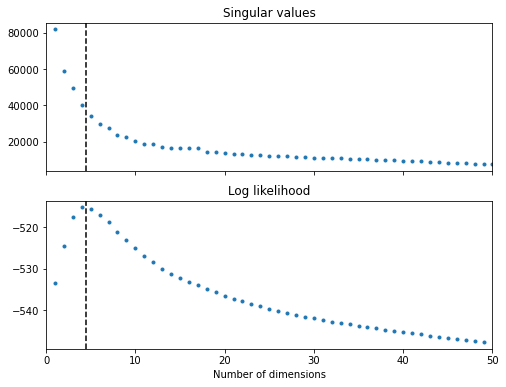

In [9]:
lq_best, lq, SA = se.dim_select(A, 50)
se.plot_dim_select(lq_best, lq, SA, max_plot=50)

The recommended embedding dimension is $d=4$ which we shall use for all entry-wise transformation of the networks; the flight counts directly, square root of the counts and the binary version of the adjacency matrix.

In [10]:
d = 4
XA_wgt = se.ASE(A, d)
XA_sqrt = se.ASE(A.sqrt(), d)
XA_bin = se.ASE(A.sign(), d)

Represent the embeddings using polar coordinates, ignoring the radius as this represents the busyness of an airport.

In [11]:
def polar_coords(x):
    d = len(x)
    theta = np.zeros(d-1)
    
    if x[0] > 0:
        theta[0] = np.arccos(x[1] / np.linalg.norm(x[:2]))
    else:
        theta[0] = 2*np.pi - np.arccos(x[1] / np.linalg.norm(x[:2]))
        
    for i in range(d-1):
        theta[i] = np.arccos(x[i+1] / np.linalg.norm(x[:(i+2)]))
        
    return theta

In [12]:
XD_wgt = np.zeros((n,d-1))
XD_sqrt = np.zeros((n,d-1))
XD_bin = np.zeros((n,d-1))

for i in range(n):
    XD_wgt[i] = polar_coords(XA_wgt[i])
    XD_sqrt[i] = polar_coords(XA_sqrt[i])
    XD_bin[i] = polar_coords(XA_bin[i])

Plot the first two dimensions of the polar coordinates for the embeddings for the three different representations of the flight network data.

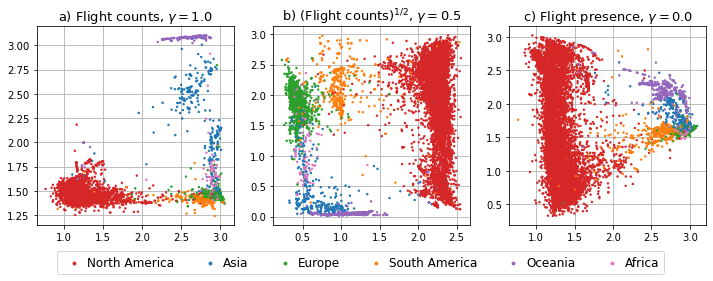

In [13]:
idx = np.where(np.array([np.linalg.norm(XA_wgt[i]) for i in range(n)]) > 1e-12)[0]

fig, axs = plt.subplots(1, 3, figsize=(12.0,4.0))

axs[0].grid(); axs[0].set_axisbelow(True)
axs[1].grid(); axs[1].set_axisbelow(True)
axs[2].grid(); axs[2].set_axisbelow(True)

axs[0].scatter(XD_wgt[idx,0], XD_wgt[idx,1], marker='.', s=8, c=Z_colours[idx])
axs[1].scatter(XD_sqrt[idx,0], XD_sqrt[idx,1], marker='.', s=8, c=Z_colours[idx])
axs[2].scatter(XD_bin[idx,0], XD_bin[idx,1], marker='.', s=8, c=Z_colours[idx])

axs[0].set_title('a) Flight counts, $\gamma=1.0$', fontsize=13)
axs[1].set_title('b) (Flight counts)$^{1/2}$, $\gamma=0.5$', fontsize=13)
axs[2].set_title('c) Flight presence, $\gamma=0.0$', fontsize=13)

fig.legend(handles=handles, bbox_to_anchor=(0.5,0), loc='lower center', ncol=6, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom = 0.19);